# Generative adversial network

## There are some TODOs in this Notebook:
- TODO#1: (as always) read the codes and comments from begining to the end.
- TODO#2: add early stopping to the training process
- TODO#3: add tensorboard for visualizing the computational graph and training parameters.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/sonvx/anaconda2/envs/ipykernel_py3_ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!ls '../../../my_data/'

mnist			   tf_logs_scalars  tf_transformers_logs
t10k-images-idx3-ubyte.gz  tf_logs_tb	    train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  tf_rnn_logs	    train-labels-idx1-ubyte.gz


In [3]:
# Getting the mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../my_data/mnist", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../my_data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../my_data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../../my_data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../../../my_data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


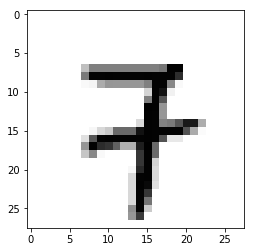

In [4]:
# Let's see one image
plt.imshow(mnist.train.images[14].reshape(28,28), cmap='Greys')

In [5]:
tf.reset_default_graph()
# Define architecture for the generator
def generator(z, reuse=None):
    # To have moduler section/sub-section can be reused.
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128)
        # activation function: leaky rectify unit
        hidden1 = tf.nn.leaky_relu(hidden1, alpha=0.01)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        
        # activation function: leaky rectify unit
        hidden2 = tf.nn.leaky_relu(hidden1, alpha=0.01)
        
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        
        return output

In [6]:
# Define architecture for the discriminator
def discriminator(X, reuse=None):
    # To have moduler section/sub-section can be reused.
    with tf.variable_scope('dis', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X, units=128)
        # activation function: leaky rectify unit
        hidden1 = tf.nn.leaky_relu(hidden1, alpha=0.01)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        
        # activation function: leaky rectify unit
        hidden2 = tf.nn.leaky_relu(hidden1, alpha=0.01)
        
        # Not this, but we need to know true/false
        # output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        
        return output, logits

In [7]:
# Define placeholder for feeding data
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100]) # 100 random points

In [8]:
# Now, define the generator
G = generator(z)

In [9]:
# Need to train the discriminator first, to classify the generated images from generator
D_output_real, D_logits_real = discriminator(real_images)

In [10]:
# Remember to set reuse=True
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

In [11]:
# Loses
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits_in, labels=labels_in
    ))

In [12]:
# Get loses of discriminator
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9) # smoothing factor
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real)) # D_logits_real can also be D_logits_fake, doesn't matter here

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

In [15]:
learning_rate = 0.0001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)

In [18]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [19]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [20]:
batch_size = 100
# Change to less epoch if your machine is slow.
epochs = 500
show_steps = 100

In [21]:
init = tf.global_variables_initializer()

In [22]:
samples = []

In [23]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        # get number of batches to finish one epoch
        num_batches = mnist.train.num_examples //batch_size
        for i in range(num_batches):
            
            batch = mnist.train.next_batch(batch_size)
            batch_images = batch[0].reshape((batch_size, 784))
            
            batch_images = batch_images* 2 - 1

            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            
            _ = sess.run(D_trainer, feed_dict = {real_images: batch_images, z:batch_z})
            
            _ = sess.run(G_trainer, feed_dict = {z:batch_z})
        
        if epoch % show_steps == 0:
            print("ON EPOCH {}".format(epoch))
        
        sample_z = np.random.uniform(-1, 1, size=(1, 100)) # one sample of 100 noises?
        
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
        
        samples.append(gen_sample)

ON EPOCH 0
ON EPOCH 100
ON EPOCH 200
ON EPOCH 300
ON EPOCH 400


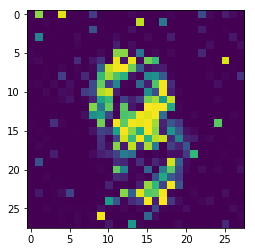

In [43]:
plt.imshow(samples[199].reshape(28,28))

In [ ]:
### 

# Conclusions: after this Notebook, you should know:
- How to train GAN network.
- How to add Tensorboard to visualize the computational graph.